In [1]:
#| echo: false
import logging
import warnings

In [2]:
#| echo: false
warnings.simplefilter('ignore')
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Trajectory Simulation

> This tutorial demonstrates how to generate sample trajectories (simulated paths) using StatsForecast.

::: {.callout-warning collapse="true"}

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short) 

:::

## Introduction 

While standard forecasting methods often produce a single point forecast or prediction intervals, some scenarios require understanding the full range of possible future paths. **Trajectory simulation** allows you to generate multiple possible future realizations of a time series based on the fitted model's error distribution.

This is particularly useful for:
- Risk analysis and stress testing.
- Scenario planning (e.g., "what if" analyses).
- Calculating complex metrics based on future paths (e.g., probability of breach).

By the end of this tutorial, you'll be able to use the `simulate` method in `StatsForecast` to generate and visualize these paths using various error distributions. 

::: {.callout-important}
## Important 
Trajectory simulation is currently supported for `AutoARIMA` and other statistical models that implement the `simulate` interface.

:::

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Basic simulation (Normal Distribution)
4. Automatic parameter inference
5. User-provided parameters
6. Comparing distributions
7. Handling large simulations

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

In [ ]:
%pip install -U statsforecast

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

## Load and explore the data

We'll use a subset of the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). 

In [4]:
df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
df = df[df['unique_id'] == 'H1'] # Focus on one series for clarity
df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


## Basic Simulation (Normal Distribution)

A simulation is performed by calling the `simulate` method after fitting. By default, it samples from a Normal distribution using the model's estimated variance from the residuals.

In [ ]:
# Initialize the model
models = [AutoARIMA(season_length=24)]
sf = StatsForecast(models=models, freq=1, n_jobs=1)

# Simulate 100 paths for a horizon of 48 hours
n_paths = 100
h = 48
# The simulation method handles the fitting (if needed) and the simulation
sims = sf.simulate(df=df, h=h, n_paths=n_paths, seed=42)

sims.head()

,unique_id,ds,sample_id,AutoARIMA
0,H1,749,0,610.915688
0,H1,750,0,563.314544
0,H1,751,0,538.771083
0,H1,752,0,519.682203
0,H1,753,0,514.878641


The output contains a `sample_id` column to distinguish between different trajectories.

## Automatic Parameter Inference

StatsForecast can automatically infer distribution parameters from your model's residuals. When you don't specify `error_params`, the system uses Maximum Likelihood Estimation (MLE) to fit the distribution parameters to the residuals.

This is particularly useful when you want the simulation to reflect the actual characteristics of your data's errors.

### Supported Distributions

- **'normal'**: Standard normal distribution (default)
- **'t'**: Student's t-distribution (heavy tails, good for financial data)
- **'bootstrap'**: Resample from empirical residuals (non-parametric)
- **'laplace'**: Laplace distribution (sharper peak, heavier tails)
- **'skew-normal'**: Skewed normal distribution (for asymmetric errors)
- **'ged'**: Generalized Error Distribution (flexible shape)

Let's demonstrate with different distributions. Note that parameters are automatically estimated from residuals.

In [6]:
# Student's t-distribution with automatic parameter inference
# The degrees of freedom, location, and scale are automatically estimated from residuals
sims_t_auto = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='t',  # No error_params specified - parameters inferred automatically
    seed=42
)

# Laplace distribution with automatic parameter inference
sims_laplace = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='laplace',
    seed=42
)

# Skew-normal distribution with automatic parameter inference
sims_skewnorm = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='skew-normal',
    seed=42
)

## User-Provided Parameters

Instead of relying on automatic inference, you can explicitly specify distribution parameters using the `error_params` dictionary. This gives you precise control over the simulation characteristics.

This is useful when:
- You have domain knowledge about the error distribution
- You want to stress-test with extreme scenarios
- You want to ensure consistency across different datasets

### Parameter Specifications

- **'t'**: `{'df': degrees_of_freedom}` - Controls tail heaviness (lower = heavier tails)
- **'skew-normal'**: `{'skewness': alpha}` - Controls asymmetry (negative = left skew, positive = right skew)
- **'ged'**: `{'shape': beta}` - Controls tail behavior (1 = Laplace, 2 = Normal, higher = lighter tails)

In [7]:
# Student's t with very heavy tails (low df = more extreme values)
sims_t_heavy = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='t',
    error_params={'df': 3},  # Heavy tails for stress testing
    seed=42
)

# Skew-normal with right skew (for positively skewed errors)
sims_skewnorm_custom = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='skew-normal',
    error_params={'skewness': 3},  # Positive skew
    seed=42
)

# GED with Laplace-like behavior (shape=1)
sims_ged = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='ged',
    error_params={'shape': 1},  # Laplace-like (sharper peak)
    seed=42
)

# Bootstrap resampling from residuals (non-parametric)
sims_boot = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='bootstrap',
    seed=42
)

## Comparing Distributions

Let's visualize the differences between automatic inference and user-provided parameters. We'll compare:

1. **Normal** - The baseline distribution
2. **t-distribution (automatic)** - Parameters estimated from residuals
3. **t-distribution (df=3)** - User-specified heavy tails for stress testing
4. **Bootstrap** - Non-parametric resampling from actual residuals

1. Normal Distribution (Baseline)


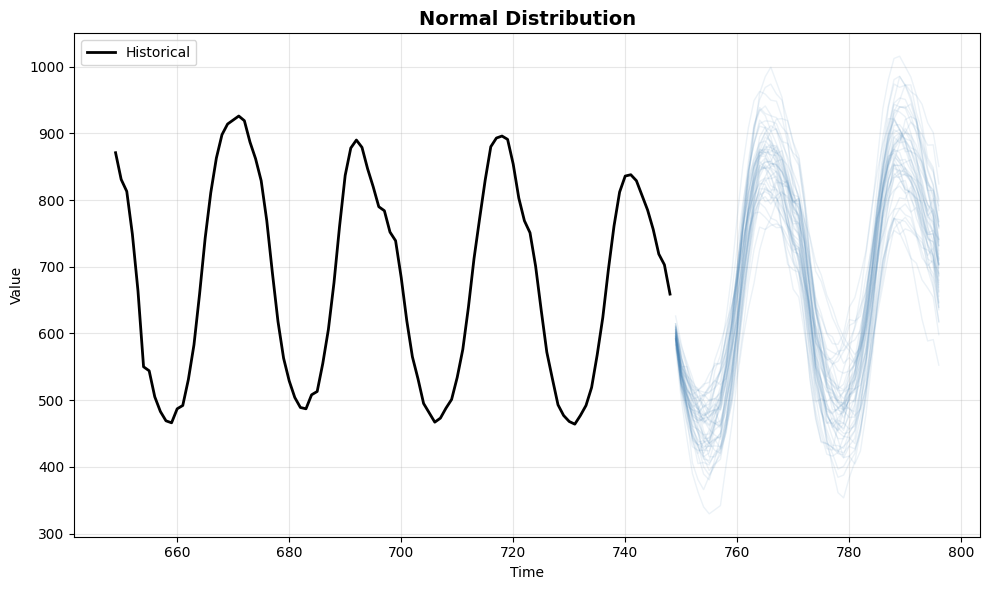


2. t-Distribution with Automatic Parameter Inference


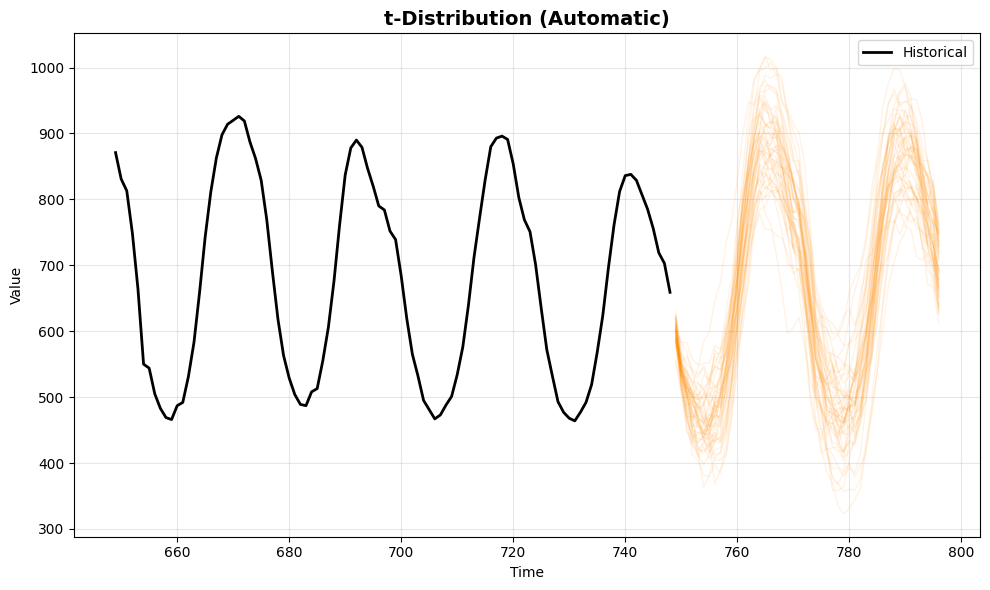


3. t-Distribution with Heavy Tails (df=3, User-Specified)


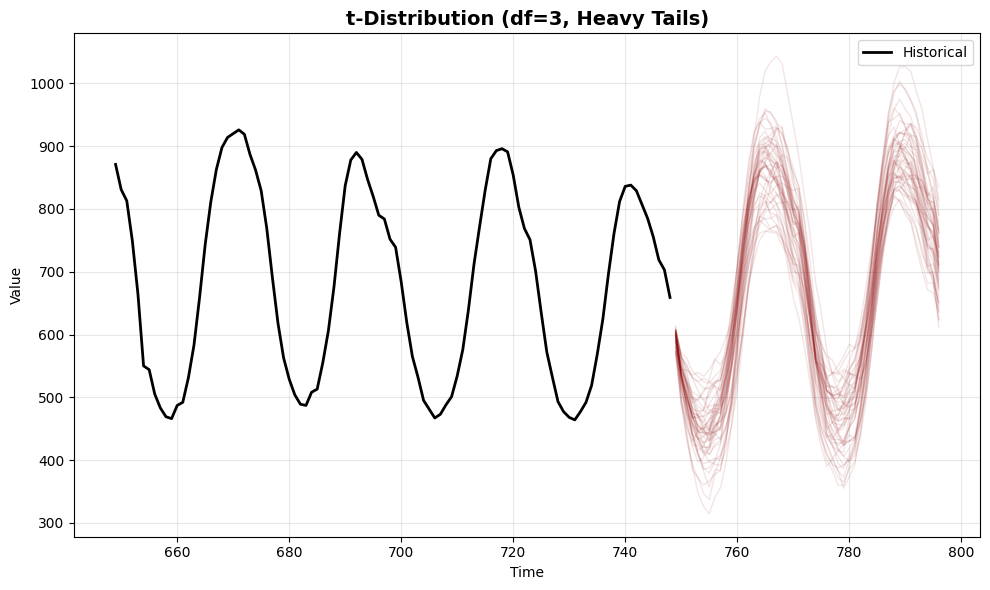


4. Bootstrap (Non-parametric)


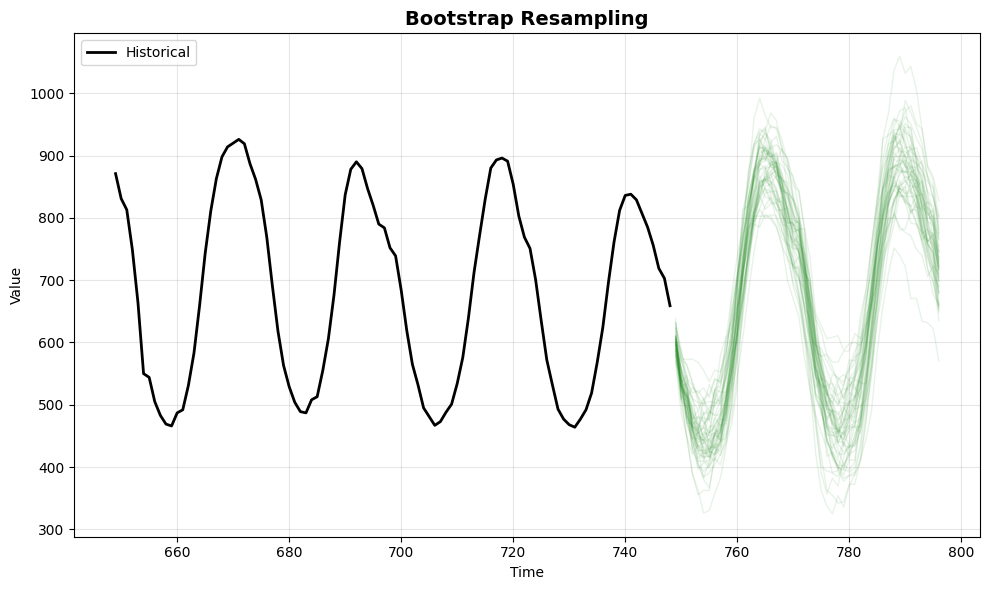

In [8]:
def plot_sims(df, sims, title, color='blue'):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Last 100 historical points
    hist = df.tail(100)
    ax.plot(hist['ds'], hist['y'], color='black', label='Historical', linewidth=2)
    
    # Identify model column
    model_col = [c for c in sims.columns if c not in ['unique_id', 'ds', 'sample_id']][0]
    
    # Plot first 50 simulation paths for clarity
    for x in range(50):
        path = sims[sims['sample_id'] == x]
        ax.plot(path['ds'], path[model_col], color=color, alpha=0.1, linewidth=1)
        
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Compare different approaches
print("1. Normal Distribution (Baseline)")
plot_sims(df, sims, 'Normal Distribution', color='steelblue')

print("\n2. t-Distribution with Automatic Parameter Inference")
plot_sims(df, sims_t_auto, 't-Distribution (Automatic)', color='darkorange')

print("\n3. t-Distribution with Heavy Tails (df=3, User-Specified)")
plot_sims(df, sims_t_heavy, 't-Distribution (df=3, Heavy Tails)', color='darkred')

print("\n4. Bootstrap (Non-parametric)")
plot_sims(df, sims_boot, 'Bootstrap Resampling', color='forestgreen')

### Key Observations

1. **Normal distribution** provides symmetric paths around the mean - suitable when errors are well-behaved
2. **t-distribution (automatic)** adapts to the data's error characteristics, producing paths that reflect the actual residual distribution
3. **t-distribution (df=3)** with user-specified parameters creates more extreme scenarios, useful for stress testing and risk analysis
4. **Bootstrap** uses the empirical error distribution directly, making no parametric assumptions

**When to use automatic inference:**
- You want simulations that reflect your data's actual error characteristics
- You don't have prior knowledge about the error distribution
- You want the model to learn from the residuals

**When to provide custom parameters:**
- You have domain expertise about the error distribution
- You want to test specific scenarios (e.g., extreme market conditions)
- You need reproducible behavior across different datasets
- You want to explore "what-if" scenarios with controlled assumptions

### Quantitative Comparison

Let's examine the statistical properties of the simulated paths to understand how each distribution affects the forecasts.

In [11]:
# Extract the model column name
model_col = 'AutoARIMA'

# Compare statistics across distributions
comparison_data = []

for name, sim_data in [
    ('Normal', sims),
    ('t (Auto)', sims_t_auto),
    ('t (df=3)', sims_t_heavy),
    ('Bootstrap', sims_boot),
]:
    values = sim_data[model_col].values
    comparison_data.append({
        'Distribution': name,
        'Mean': f"{np.mean(values):.2f}",
        'Std Dev': f"{np.std(values):.2f}",
        'Min': f"{np.min(values):.2f}",
        'Max': f"{np.max(values):.2f}",
        '5th percentile': f"{np.percentile(values, 5):.2f}",
        '95th percentile': f"{np.percentile(values, 95):.2f}",
    })

comparison_df = pd.DataFrame(comparison_data)
print("Statistical Comparison of Simulated Trajectories:")
print("=" * 80)
print(comparison_df.to_string(index=False))

Statistical Comparison of Simulated Trajectories:
Distribution   Mean Std Dev    Min     Max 5th percentile 95th percentile
      Normal 670.15  161.78 307.35 1015.69         433.04          910.30
    t (Auto) 669.82  164.69 306.78 1027.63         431.49          914.23
    t (df=3) 667.69  164.39 314.33 1043.34         430.01          907.51
   Bootstrap 669.94  165.51 324.97 1059.47         429.79          913.07


## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, The Statistical Forecasting Perspective"](https://otexts.com/fpp3/perspective.html).